In [1]:
import os, time, copy
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from random import seed, shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
from utils.myutils import *
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 设置TensorFlow的日志级别为2，只显示error和warining信息
from tensorflow.keras.regularizers import l2,l1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.get_logger().setLevel('ERROR') #删除多余的日志

import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten,Reshape, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPool2D, Concatenate
from keras.optimizers import adam_v2
import os, time, copy
from glob import glob

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
# 导入functools模块早停
import functools
import math  # 导入 math 模块

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#data_path = "./data/slices60/3d_xiao/"  # 数据路径
data_path = "./data/slices60/3d_xiao/"  # 数据路径
model_path = "./model/VGG16/"  # 设置模型保存目录
# 创建目录
for path in [model_path]:
    print(path)
    if not os.path.exists(path):
        os.makedirs(path)

./model/VGG16/


## 1.读取数据表


In [3]:
# 读入结节信息
dat = pd.read_csv("/course75/RealData/是否微乳头-给学生_0609.csv",encoding = 'GBK')
dat = dat.sort_values(by=["ID", "Z"]).reset_index(drop=True)  # 按ID和Z轴位置升序排列
dat

,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,微乳头型,实体型,STAS,胸膜受累,脉管瘤栓,淋巴结转移,flag_1,flag_2,flag_3,flag
0,7,157,222,242-257,右肺,中叶,纯磨玻璃,MIA,NaN,1.50,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,10,365,375,107-118,左肺,下叶,混杂密度,MIA,NaN,0.80,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,13,185,375,97-118,右肺,上叶,纯实性,腺癌,3.0,2.70,...,NaN,主要,无,有,无,无,0,1,0,1
3,16,328,388,238-252,左肺,下叶,部分实性,粘液腺癌,1.0,0.90,...,NaN,NaN,无,无,无,无,0,0,0,0
4,17,145,328,93-114,右肺,上叶,部分实性,腺癌,1.0,1.20,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,629,149,311,145-168,右肺,下叶,纯实性,腺癌,2.0,3.70,...,少量,NaN,无,无,有,无,1,0,0,1
479,630,352,322,226-238,左肺,下叶,纯实性,腺癌,2.0,0.85,...,NaN,NaN,无,无,无,无,0,0,0,0
480,631,109,362,204-218,右肺,下叶,纯磨玻璃,MIA,NaN,1.28,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
481,632,293,291,16-29,左肺,上叶,纯实性,腺癌,3.0,1.30,...,部分,局部,无,无,有,无,1,1,0,1


In [4]:
datflag = dat.dropna(axis=0,subset=['flag'],inplace=False)#删flag列为空值的行修改原数据的副本形成新数据
# 提取切片depth维度和结节对应的切片张数
datflag["Zrange"] = datflag["Z"].apply(lambda x: sorted(map(lambda y: int(y)-1, x.split("-"))))  # 索引起点归0,例：242-257→[241,256]
datflag["Zmed"] = datflag["Zrange"].apply(lambda x: int((x[1]+x[0])/2))  # 计算中心切片位置
datflag["slices"] = datflag["Zrange"].apply(lambda x: x[1]-x[0]+1)  # 计算结节切片数
# 设置结节编号，从0开始计数
datflag["nID"] = datflag.index
datflag

,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,脉管瘤栓,淋巴结转移,flag_1,flag_2,flag_3,flag,Zrange,Zmed,slices,nID
0,7,157,222,242-257,右肺,中叶,纯磨玻璃,MIA,NaN,1.50,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
1,10,365,375,107-118,左肺,下叶,混杂密度,MIA,NaN,0.80,...,NaN,NaN,0,0,0,0,"[106, 117]",111,12,1
2,13,185,375,97-118,右肺,上叶,纯实性,腺癌,3.0,2.70,...,无,无,0,1,0,1,"[96, 117]",106,22,2
3,16,328,388,238-252,左肺,下叶,部分实性,粘液腺癌,1.0,0.90,...,无,无,0,0,0,0,"[237, 251]",244,15,3
4,17,145,328,93-114,右肺,上叶,部分实性,腺癌,1.0,1.20,...,NaN,NaN,0,0,0,0,"[92, 113]",102,22,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,629,149,311,145-168,右肺,下叶,纯实性,腺癌,2.0,3.70,...,有,无,1,0,0,1,"[144, 167]",155,24,478
479,630,352,322,226-238,左肺,下叶,纯实性,腺癌,2.0,0.85,...,无,无,0,0,0,0,"[225, 237]",231,13,479
480,631,109,362,204-218,右肺,下叶,纯磨玻璃,MIA,NaN,1.28,...,NaN,NaN,0,0,0,0,"[203, 217]",210,15,480
481,632,293,291,16-29,左肺,上叶,纯实性,腺癌,3.0,1.30,...,有,无,1,1,0,1,"[15, 28]",21,14,481


# 2.划分训练集、验证集、测试集
#### 复现VGG16+CBAM的划分情况

In [5]:
IDs = pd.read_csv("/mnt/GCNxin/output.csv", encoding = 'utf-8', low_memory=False)
IDs

,train_IDs,valid_IDs,test_IDs
0,98,63.0,191.0
1,626,268.0,543.0
2,589,380.0,177.0
3,454,183.0,267.0
4,231,375.0,540.0
...,...,...,...
250,173,NaN,NaN
251,436,NaN,NaN
252,595,NaN,NaN
253,621,NaN,NaN


In [6]:
train_IDs_list = IDs['train_IDs'].dropna().astype(int).tolist() #将病人ID删除缺失值后以整数型数据保存为列表
test_IDs_list = IDs['test_IDs'].dropna().astype(int).tolist()
valid_IDs_list = IDs['valid_IDs'].dropna().astype(int).tolist()
train_IDs_listzong=train_IDs_list+valid_IDs_list # 获取训练集和验证集病人ID序列和
print(train_IDs_list)
print(test_IDs_list)
print(valid_IDs_list)
# 提取符合条件的切片，即 dat_cut DataFrame 中 ID 列属于 train_IDs_list 的切片
#train_slices = dat_cut[dat_cut['ID'].isin(train_IDs_list)]
#train_slices.reset_index(drop=True, inplace=True)
type(test_IDs_list)
len(train_IDs_listzong)

[98, 626, 589, 454, 231, 230, 119, 163, 568, 398, 461, 404, 444, 84, 284, 549, 574, 627, 562, 27, 312, 85, 510, 339, 203, 414, 580, 297, 519, 498, 400, 132, 298, 350, 402, 176, 430, 317, 114, 555, 167, 250, 333, 448, 55, 458, 281, 480, 272, 26, 277, 289, 299, 417, 296, 547, 566, 603, 273, 438, 354, 346, 386, 31, 511, 429, 310, 201, 550, 325, 295, 393, 249, 142, 171, 168, 399, 150, 185, 453, 258, 44, 366, 77, 497, 136, 394, 565, 587, 321, 349, 373, 304, 33, 66, 504, 544, 396, 523, 356, 599, 293, 209, 324, 329, 248, 166, 413, 422, 487, 144, 408, 336, 83, 90, 237, 22, 484, 631, 303, 502, 241, 216, 331, 283, 145, 632, 48, 246, 431, 172, 121, 35, 623, 184, 53, 598, 614, 352, 327, 579, 462, 360, 158, 219, 467, 612, 611, 357, 501, 524, 180, 575, 178, 68, 42, 266, 337, 343, 30, 622, 456, 530, 538, 29, 397, 257, 577, 139, 76, 286, 583, 131, 236, 395, 443, 18, 122, 368, 234, 425, 529, 221, 170, 433, 164, 481, 88, 572, 213, 592, 243, 278, 37, 32, 548, 485, 308, 154, 56, 471, 188, 156, 316, 446, 3

340

In [7]:
def psplitDF8(data, col_name, reset, train_IDs, test_IDs, seed=123, shuffle=False):
    # 得到两个数据集
    train_dat = data.loc[data[col_name].isin(train_IDs), ]  # 训练集
    test_dat = data.loc[data[col_name].isin(test_IDs), ]  # 测试集
    if reset == True:  # 判断是在划分训练集和测试集，还是在划分训练集和验证集
        train_dat = train_dat.reset_index(drop=True)  # 重设索引为连续的整数，从0开始
        test_dat = test_dat.reset_index(drop=True)
        train_index = list(range(len(train_dat)))  # 更新 train_index，使用range函数生成从0开始的连续整数序列
        test_index = list(range(len(test_dat)))  # 更新 test_index，使用range函数生成从0开始的连续整数序列
    else:
        # 提取索引，用于模型训练
        train_index = train_dat.index.tolist()  # 训练集索引
        test_index = test_dat.index.tolist()  # 测试集索引
    # 返回训练集表、测试集表、训练集表索引、测试集表索引
    return train_dat, test_dat, train_index, test_index

In [8]:
train_dat, test_dat, _, test_index = psplitDF8(datflag, "ID",  train_IDs=train_IDs_listzong,test_IDs= test_IDs_list, reset=True)  # 按病人ID划分为训练集和测试集
len(train_dat)
train_datz, valid_dat, train_index, valid_index = psplitDF8(train_dat, "ID", train_IDs=train_IDs_list,test_IDs= valid_IDs_list,reset=False)  # 按病人ID将训练集再划分为训练集和验证集

print(f"训练数据中训练集{pcalRate(train_dat, train_index)}")
print(f"训练数据中验证集{pcalRate(train_dat, valid_index)}")
print(f"测试数据中测试集{pcalRate(test_dat, test_index)}")
print(f"训练集: {train_index[:5]}")
print(f"验证集: {valid_index[5]}")
print(f"测试集: {test_index}")
len(train_index)
len(valid_index)

训练数据中训练集切片数: 291，微乳头切片占比: 29.55%，结节数: 291, 微乳头结节占比：30.82%，病人数: 255
训练数据中验证集切片数: 99，微乳头切片占比: 27.27%，结节数: 99, 微乳头结节占比：30.59%，病人数: 85
测试数据中测试集切片数: 93，微乳头切片占比: 27.96%，结节数: 93, 微乳头结节占比：27.91%，病人数: 86
训练集: [2, 4, 5, 6, 7]
验证集: 22
测试集: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]


99

In [9]:
train_datz

,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,脉管瘤栓,淋巴结转移,flag_1,flag_2,flag_3,flag,Zrange,Zmed,slices,nID
2,18,195,336,183-229,右肺,下叶,纯实性,腺癌,3.0,3.30,...,无,无,1,1,1,1,"[182, 228]",205,47,5
4,20,386,266,311-376,左肺,下叶,纯实性,非小细胞肺癌,3.0,4.10,...,无,无,0,0,0,0,"[310, 375]",342,66,7
5,22,105,271,165-173,右肺,上叶,部分实性,MIA,NaN,0.85,...,NaN,NaN,0,0,0,0,"[164, 172]",168,9,9
6,26,369,331,35-40,左肺,上叶,混杂密度,腺癌,1.0,0.95,...,无,NaN,0,0,0,0,"[34, 39]",36,6,10
7,27,364,276,104-127,左肺,上叶,部分实性,腺癌,2.0,1.20,...,无,无,1,0,0,1,"[103, 126]",114,24,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,623,134,212,203-234,右肺,中叶,纯实性,腺癌,2.0,2.10,...,无,无,0,0,0,0,"[202, 233]",217,32,474
385,626,376,383,45-64,左肺,上叶,部分实性,腺癌,1.0,1.85,...,无,无,0,0,0,0,"[44, 63]",53,20,476
386,627,418,279,324-334,左肺,下叶,混杂密度,腺癌,1.0,0.80,...,无,无,0,0,0,0,"[323, 333]",328,11,477
387,631,109,362,204-218,右肺,下叶,纯磨玻璃,MIA,NaN,1.28,...,NaN,NaN,0,0,0,0,"[203, 217]",210,15,480


In [10]:
#得到各数据集无重复的ID值
tra_seq=train_datz["ID"].unique()
val_seq=valid_dat["ID"].unique()
tes_seq=test_dat["ID"].unique()
len(tes_seq)
print(tra_seq)
print(tes_seq)
print(len(tra_seq))
print(len(tes_seq))
print(len(val_seq))
tes_seq[0]

[ 18  20  22  26  27  29  30  31  32  33  35  37  42  44  48  53  55  56
  60  64  66  68  76  77  83  84  85  88  90  95  98 100 101 104 111 114
 119 121 122 127 131 132 136 139 142 144 145 147 150 154 156 158 159 163
 164 166 167 168 170 171 172 173 176 178 179 180 184 185 188 194 198 201
 203 209 213 216 219 221 222 223 230 231 234 236 237 241 243 244 246 248
 249 250 257 258 266 272 273 277 278 281 283 284 286 289 290 293 295 296
 297 298 299 303 304 308 310 312 316 317 321 324 325 327 328 329 331 332
 333 336 337 339 340 341 343 346 349 350 352 353 354 356 357 360 362 366
 368 373 386 387 390 393 394 395 396 397 398 399 400 402 404 408 413 414
 417 422 425 426 429 430 431 433 436 437 438 443 444 446 448 453 454 456
 458 461 462 467 471 472 474 480 481 482 484 485 487 493 496 497 498 501
 502 504 507 508 509 510 511 512 519 523 524 525 526 527 529 530 538 544
 545 547 548 549 550 555 562 563 564 565 566 568 572 574 575 576 577 579
 580 583 587 588 589 591 592 595 598 599 603 611 61

7

In [11]:
tra_image = []
val_image = []
tes_image = []

# 获取所有结节文件路径，并按指定顺序排序
imagePaths = glob(data_path + "*/*flag_*.npy")
imagePaths.sort(key=lambda x: [int(x.split("nID_")[1].split(",")[0]), int(x.split("ID_")[1].split(",")[0])], reverse=False)

# 将tra_seq、val_seq和tes_seq转换为set
tra_seq_set = set(tra_seq)
val_seq_set = set(val_seq)
tes_seq_set = set(tes_seq)
##按照ID值划分训练集、验证集、测试集
for i, image_path in enumerate(imagePaths):
    x = image_path.split(" ID_")[1].split(",")[0]
    a = int(x)
    if a in tra_seq_set:
        tra_image.append(image_path)
    elif a in val_seq_set:
        val_image.append(image_path)
    elif a in tes_seq_set:
        tes_image.append(image_path)

print("Train Images:", len(tra_image))
print("Valid Images:", len(val_image))
print("Test Images:", len(tes_image))

Train Images: 291
Valid Images: 99
Test Images: 93


#### 构建训练集y_train、测试集y_test和验证集y_valid的标签

In [12]:
#构建0-1y
y_train=[]
y_test=[]
y_valid=[]
for i in range(291):
    file_path = trainSets[i][0]  # 获取文件路径
    c = int(file_path.split('flag_')[1].split(".")[0])#提取文件路径中的标签(0或1)并将其附加到列表 y_train
    y_train.append(c)
    
for i in range(99):
    file_path = testSets[i][0]  # 获取文件路径
    c = int(file_path.split('flag_')[1].split(".")[0])
    y_test.append(c)
    
for i in range(93):
    file_path = validSets[i][0]  # 获取文件路径
    c = int(file_path.split('flag_')[1].split(".")[0])
    y_valid.append(c)  

#print(y_test)
type(y_test)
y_train=np.array(y_train)
type(y_train)
y_test=np.array(y_test)
type(y_test)
y_test.shape
type(y_valid)
y_valid=np.array(y_valid)
y_valid.shape


(99,)

In [13]:
y_train.shape
y_train=list(y_train)
y_train=np.array(y_train)
y_train.resize((291, 1))#调整y_train数组的形状为(6578, 1)
print(y_train)
y_test=list(y_test)
y_test=np.array(y_test)
y_test.resize((99, 1))#调整y_test数组的形状为(2007, 1)
y_valid=list(y_valid)
y_valid=np.array(y_valid)
y_valid.resize((93, 1))#调整y_valid数组的形状为(2278, 1)

[[1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]


(291, 1)

In [16]:
#计算验证集中微乳头切片的数量
count2=0
for i in range(93):
    if y_test[i]==1:
        count2=count2+1
print(count2)

26


In [17]:
#计算测试集中微乳头切片的数量
count3=0
for i in range(99):
    if y_valid[i]==1:
        count3=count3+1
print(count3)

27


In [18]:
#计算训练集中微乳头切片的数量
count1=0
for i in range(291):
    if y_train[i]==1:
        count1=count1+1
print(count1)

86


#### 数据预处理（单通道转RGB三通道）

In [19]:
# 读取单个npy文件
def get_data_from_file(filePath):
    img_gray = np.load(filePath)  # 读取npy，[60,60]
    img_rgb = gray2rgb(img_gray)  # 第一种办法，灰度图转RGB，[60,60,3]
    #img_rgb = np.repeat(img_gray[..., np.newaxis], 1, -1)  # 第二种办法，单通道复制为3通道，[60,60,3]
    #print(tes_image[0].shape)
    #img_rgb=tf.image.resize(img_rgb, [32,32])
    #print(resized)
    return img_rgb

# 遍历列表，读取多个npy文件，组合成一个batch
def combineBatch(paths):
    batch_data = []
    for path in paths:
        batch_data.append(get_data_from_file(path))
    return np.asarray(batch_data)  # [B,H,W,C]

#### 将切片数据分batch输入模型，得到各切片的featuremap，最后可以构成特征矩阵

In [20]:
#训练
features1 = []
batchsize = 10  # 每个batch的数据量
N = len(tra_image)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = tra_image[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    features1.append(batchData)
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
features1.append(batchData)  # 存储featuremap
features1 = np.vstack(features1)

features1.shape

100%|██████████| 29/29 [00:04<00:00,  6.62it/s]


(291, 32, 48, 48, 3)

In [21]:
#验证
features3 = []
batchsize = 10  # 每个batch的数据量
N = len(val_image)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = val_image[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    features3.append(batchData)
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
features3.append(batchData)  # 存储featuremap
features3 = np.vstack(features3)

features3.shape

100%|██████████| 9/9 [00:01<00:00,  7.97it/s]


(99, 32, 48, 48, 3)

In [22]:
type(y_test)
y_test.shape

(93, 1)

In [23]:
#测试
features2 = []
batchsize = 5  # 每个batch的数据量
N = len(tes_image)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = tes_image[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    features2.append(batchData)
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
features2.append(batchData)  # 存储featuremap
features2 = np.vstack(features2)

features2.shape

100%|██████████| 18/18 [00:00<00:00, 18.27it/s]


(93, 32, 48, 48, 3)

# 3.构建3D-ResNet模型

In [25]:
# 3D 卷积层 + 批归一化 + ReLU激活函数
def conv3d_bn_relu(x, filters, kernel_size, strides=(1, 1, 1), padding='same', use_bias=False,kernel_regularizer=None):
    x = tf.keras.layers.Conv3D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias,kernel_regularizer=kernel_regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def basic_block(x, filters, downsample, expansion=1,strides=(1, 1, 1),kernel_regularizer=None):
     # 基本的 ResNet 块
    residual = x

    x = conv3d_bn_relu(x, filters, kernel_size=3, strides=strides,kernel_regularizer=kernel_regularizer)
    x = conv3d_bn_relu(x, filters, kernel_size=3, strides=(1, 1, 1),kernel_regularizer=kernel_regularizer)

    if downsample is not None:
        residual = downsample_block(residual, filters, expansion)

    x += residual
    x = tf.keras.layers.ReLU()(x)
    return x
# 下采样块
def downsample_block(x, filters, expansion=1):
    downsampled_x = tf.keras.layers.Conv3D(filters * expansion, kernel_size=1, strides=(1, 1, 1), use_bias=False)(x)
    downsampled_x = tf.keras.layers.BatchNormalization()(downsampled_x)
    return downsampled_x

def resnet_block(x, filters, num_blocks, expansion=1):
    downsample = None
    if x.shape[-1] != filters * expansion:
        downsample = downsample_block(x, filters, expansion)  # 获取downsample的实际函数

    x = basic_block(x, filters, downsample=downsample, strides=(1, 1, 1))
    for _ in range(1, num_blocks):
        x = basic_block(x, filters, downsample=None)

    if downsample is not None:
        downsampled_x = downsample_block(x, filters, expansion)  # 调用downsample函数以获取实际的张量

        # 添加适当的卷积层来调整downsampled_x的通道数
        downsampled_x = tf.keras.layers.Conv3D(filters * expansion, kernel_size=1, strides=(1, 1, 1), use_bias=False)(downsampled_x)

        x = tf.keras.layers.add([x, downsampled_x])  # 使用tf.keras.layers.add创建添加层并相加

    x = tf.keras.layers.ReLU()(x)
    return x


def generate_model(input_shape=(32, 48, 48, 3)):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    # Block1
    x = conv3d_bn_relu(input_layer, 64, kernel_size=(7, 7, 7), strides=(2, 2, 2), padding='same', use_bias=False)
    x = tf.keras.layers.MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding='same')(x)

    # Block2 - 4
    x = resnet_block(x, 64, num_blocks=2)
    x = resnet_block(x, 128, num_blocks=2, expansion=1)
    x = resnet_block(x, 256, num_blocks=2, expansion=1)
    x = resnet_block(x, 512, num_blocks=2, expansion=1)

    # GlobalAveragePooling3D and Dense
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = layers.Dropout(0.4)(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#,kernel_regularizer=l2(0.01),activity_regularizer=l1(0.02)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# Create the model
model18 = generate_model()
model18.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 48, 48,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 16, 24, 24, 6 65856       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 24, 24, 6 256         conv3d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16, 24, 24, 6 0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### 模型编译与训练

In [27]:
# 定义学习率调度函数
def step_decay(epoch, initial_lrate, drop, epochs_drop):
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# ...

# 记录训练开始时间，同时作为保存模型文件名的前缀
train_start = time.strftime("%Y-%m-%d %H:%M:%S")
# 初始学习率为0.001，如果20个epoch后精度没有提升，学习率降低0.5；存外样本精度最高的模型
model_file = os.path.join(model_path, f'{train_start} 3d_best08.h5')
logging_file = os.path.join(model_path, f"{train_start} 3d_metric08.csv")
# 使用functools.partial定义LearningRateScheduler的学习率调度函数
callback = get_callbacks(model_file, initial_learning_rate=0.00001, learning_rate_drop=0.1, learning_rate_epochs=[20, 40, 60],
                  learning_rate_patience=10, logging_file=logging_file, verbosity=1,
                  early_stopping_patience=10, tensorboard_callback=None, 
                  learning_rate_scheduler=functools.partial(step_decay, initial_lrate=0.00001, drop=0.1, epochs_drop=20))
model18.compile(optimizer=keras.optimizers.RMSprop(0.00001),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
# 训练模型
model18.fit(features1, y_train, epochs=5, callbacks=callback, validation_data=(features3, y_valid), 
            workers=16, use_multiprocessing=True)

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/keras/backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


Train on 291 samples, validate on 99 samples


2023-08-04 04:48:50.812127: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 04:48:51.356701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10801 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:14:00.0, compute capability: 3.7


Epoch 1/5


2023-08-04 04:48:56.010840: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


291/291 [==============================] - ETA: 0s - loss: 0.9689 - binary_accuracy: 0.5326

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.66715, saving model to ./model/VGG16/2023-08-04 04:48:48 3d_best08.h5


/root/miniconda3/envs/myconda/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


291/291 [==============================] - 93s 319ms/sample - loss: 0.9689 - binary_accuracy: 0.5326 - val_loss: 0.6671 - val_binary_accuracy: 0.7071 - lr: 1.0000e-05
Epoch 2/5
291/291 [==============================] - ETA: 0s - loss: 0.6747 - binary_accuracy: 0.7010
Epoch 00002: val_loss improved from 0.66715 to 0.60749, saving model to ./model/VGG16/2023-08-04 04:48:48 3d_best08.h5
291/291 [==============================] - 77s 264ms/sample - loss: 0.6747 - binary_accuracy: 0.7010 - val_loss: 0.6075 - val_binary_accuracy: 0.7273 - lr: 1.0000e-05
Epoch 3/5
291/291 [==============================] - ETA: 0s - loss: 0.7001 - binary_accuracy: 0.6907
Epoch 00003: val_loss improved from 0.60749 to 0.57216, saving model to ./model/VGG16/2023-08-04 04:48:48 3d_best08.h5
291/291 [==============================] - 77s 264ms/sample - loss: 0.7001 - binary_accuracy: 0.6907 - val_loss: 0.5722 - val_binary_accuracy: 0.7273 - lr: 1.0000e-05
Epoch 4/5
291/291 [==============================] - ETA:

In [27]:
#用
# 记录训练开始时间，同时作为保存模型文件名的前缀
train_start = time.strftime("%Y-%m-%d %H:%M:%S")
# 初始学习率为0.001，如果20个epoch后精度没有提升，学习率降低0.5；存外样本精度最高的模型
model_file = os.path.join(model_path, f'{train_start} res_best18.h5')
logging_file = os.path.join(model_path, f"{train_start} res_metric18.csv")
callback = get_callbacks(model_file, initial_learning_rate=0.5, learning_rate_drop=0.1, learning_rate_epochs=None,
                  learning_rate_patience=20, logging_file=logging_file, verbosity=1,
                  early_stopping_patience=10,tensorboard_callback = None)
model18.compile(optimizer=keras.optimizers.RMSprop(lr=0.5),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
# 训练模型
model18.fit(features1, y_train, epochs=15, callbacks=callback, validation_data=(features2, y_test), 
            workers=16, use_multiprocessing=True)
#cbamuse_multiprocessing=True

TypeError: get_callbacks() missing 1 required positional argument: 'learning_rate_scheduler'

#### 模型预测

In [ ]:
result=model18.predict(features2) #对测试集进行模型预测
#pred = tf.argmax(result, axis=1)

print(result)

In [30]:
#计算阈值，将预测结果转换为0或1
result.max()
result.min()
result.shape
a=result.min()+(result.max()-result.min())/2
result1=result.tolist() # 将预测结果转换为列表
type(result.tolist())
pred1={}
for i in range(2007):
    if result1[i]<=a:
        pred1[i]=0
    else:
        pred1[i]=1

(93, 1)

In [34]:
#统计预测结果为1（微乳头）的数量
count=0
for i in range(93):
    if pred1[i]==1:
        count=count+1
print(count)

0


In [35]:
# 提取预测结果
#pred1=pred1.numpy()
pred1 = pred1.items()
# Convert object to a list
pred1= list(pred1) 
# Convert list to an array
pred1 = np.array(pred1) 
# print the numpy array
print(type(pred1))
#type(y_test)
print(type(result))
pred=pred1[:,1]
pred

<class 'numpy.ndarray'>


# 4.模型评估

Confusion matrix, without normalization
[[60  7]
 [17  9]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
0,0.741935,0.895522,0.346154,0.5625,0.779221,0.428571,0.741935,0.774397


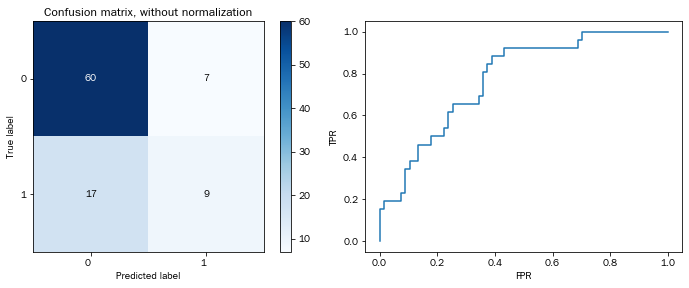

In [36]:
#切片层面
labels_value = np.array([0, 1])
tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=labels_value).ravel() ##ravel数组维度拉成一维数组
    # Accuracy
acc1 = accuracy_score(y_test, pred)
#     print("Accuracy:{:.4f}".format(acc1))
    # 特异性：TN / N
specificity = tn / (tn+fp)
    # 敏感度：TP / P
sensitivity= tp/(tp+fn)
    # Positive predictive value PPV = TP / (TP + FP)
ppv = tp / (tp+fp)
    # Negative predictive value NPV = TN / (TN + FN)
npv = tn / (tn+fn)
    # F1-score
f1 = f1_score(y_test, pred) ##结果是类别1的score
acc2 = accuracy_score(y_test, pred)
    # ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, result[:])
roc_auc = auc(fpr, tpr)
    # 最佳阈值
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
bestThresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]] ##argsort数组中的元素从小到大排序后的索引数组值
title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
cm = confusion_matrix(y_test, pred)
    # Only use the labels that appear in the data
classes = labels_value[unique_labels(y_test, pred)]
print('Confusion matrix, without normalization')
print(cm)
#     fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

ax.set_ylim(len(classes)-0.5, -0.5)
    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")  
    # Loop over data dimensions and create text annotations.
fmt = 'd' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    # 绘制ROC曲线
ax = fig.add_subplot(122)
ax.plot(fpr, tpr, label='ROC')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
    
    # 整合评估指标
metrics_s = pd.DataFrame({"ACC_pred": [acc1], "Specificity": [specificity], "Sensitivity": [sensitivity],
                            "PPV": [ppv], "NPV": [npv], "F1-Score": [f1], "ACC_argmax": [acc2], "AUC": [roc_auc]})
    
fig.tight_layout()
metrics_s


In [37]:
#计算结节层面的预测结果
pthresh=0.5
if test_index is None:
    noduleData = test_dat.loc[:, ["nID", "ID", "flag"]].copy()  # copy测试集原数据
else:
    noduleData = test_dat.loc[test_index, ["nID", "ID", "flag"]].copy()  # 复制测试集指定索引的数据
noduleData["y_pred"] = pred
noduleData["0_value"] = result
noduleData = noduleData.groupby("nID").mean()  # 平均法
noduleData[["ID","flag"]] = noduleData[["ID", "flag"]].astype(int)  # 保持数据类型
noduleData["voting_pred"] = noduleData["y_pred"].apply(lambda x: 1 if x > pthresh else 0)  # 投票法得到预测标签，90%阈值
#compreEval(noduleData["flag"], noduleData["voting_pred"], np.asarray(noduleData["0_value"]), classes=labels_value, normalize=False)

Confusion matrix, without normalization
[[60  7]
 [17  9]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
0,0.741935,0.895522,0.346154,0.5625,0.779221,0.428571,0.741935,0.774397


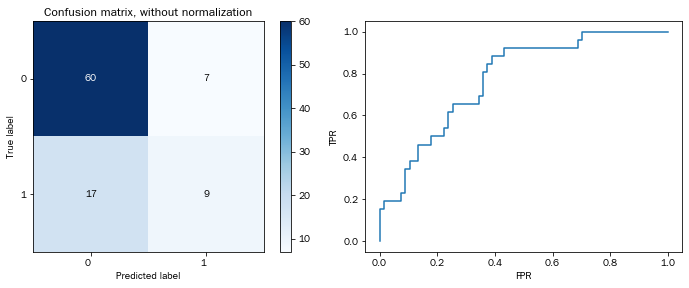

In [38]:
# 结节层面
tn, fp, fn, tp = confusion_matrix(noduleData["flag"], noduleData["voting_pred"], labels=labels_value).ravel() ##ravel数组维度拉成一维数组
    # Accuracy
acc1 = accuracy_score(noduleData["flag"], noduleData["voting_pred"])
#     print("Accuracy:{:.4f}".format(acc1))
    # 特异性：TN / N
specificity = tn / (tn+fp)
    # 敏感度：TP / P
sensitivity= tp/(tp+fn)
    # Positive predictive value PPV = TP / (TP + FP)
ppv = tp / (tp+fp)
    # Negative predictive value NPV = TN / (TN + FN)
npv = tn / (tn+fn)
    # F1-score
f1 = f1_score(noduleData["flag"], noduleData["voting_pred"]) ##结果是类别1的score
acc2 = accuracy_score(noduleData["flag"], noduleData["voting_pred"])
    # ROC曲线
fpr, tpr, thresholds = roc_curve(noduleData["flag"], np.asarray(noduleData["0_value"]))
roc_auc = auc(fpr, tpr)
    # 最佳阈值
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
bestThresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]] ##argsort数组中的元素从小到大排序后的索引数组值
title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
cm = confusion_matrix(noduleData["flag"], noduleData["voting_pred"])
    # Only use the labels that appear in the data
classes = labels_value[unique_labels(noduleData["flag"], noduleData["voting_pred"])]
print('Confusion matrix, without normalization')
print(cm)
#     fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')
ax.set_ylim(len(classes)-0.5, -0.5)
    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")  
    # Loop over data dimensions and create text annotations.
fmt = 'd' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    # 绘制ROC曲线
ax = fig.add_subplot(122)
ax.plot(fpr, tpr, label='ROC')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
    # 整合评估指标
metrics_n = pd.DataFrame({"ACC_pred": [acc1], "Specificity": [specificity], "Sensitivity": [sensitivity],
                            "PPV": [ppv], "NPV": [npv], "F1-Score": [f1], "ACC_argmax": [acc2], "AUC": [roc_auc]})
fig.tight_layout()
metrics_n
